## Aims:
Differentiate various organs in the mask

In [4]:
import torch
import torch.nn as nn
from pathlib import Path
import numpy as np
import random
from shutil import copyfile
import os

import torch
import torch.nn as nn
from pathlib import Path
import numpy as np
import random
from shutil import copyfile
import os

# Set the random seed for reproducibility
random.seed(2056)

# Read all files ending with _img.nii
img_path = Path("data/data")
img_files = list(img_path.glob("*_img.nii")) # Image and mask are in the same folder
num_images = len(img_files) 

# Create train, validation and test splits
train_split = int(0.7 * num_images)
val_split = int(0.15 * num_images)
test_split = int(num_images - (train_split + val_split))

# Shuffle the image files
random.shuffle(img_files)

# Split the dataset
train_images = img_files[:train_split]
val_images = img_files[train_split:(train_split + val_split)]
test_images = img_files[(train_split + val_split): ]

# Create train, validation and test directories
train_image_dir = Path(img_path / "train_images")
train_mask_dir = Path(img_path / "train_masks")
val_image_dir = Path(img_path / "val_images")
val_mask_dir = Path(img_path / "val_masks")
test_image_dir = Path(img_path / "test_images")
test_mask_dir = Path(img_path / "test_masks")

# Create the directories if they don't exist
if not os.path.exists(train_image_dir) and not os.path.exists(train_mask_dir) and not os.path.exists(val_image_dir) and not os.path.exists(val_mask_dir) and not os.path.exists(test_image_dir) and not os.path.exists(test_mask_dir):
    for directory in [train_image_dir, train_mask_dir, val_image_dir, val_mask_dir, test_image_dir, test_mask_dir]:
        directory.mkdir(exist_ok = True, parents = True)

    # Copy the images and their corresponding segmentation masks to their respective directories
    for directory, images in zip([train_image_dir, val_image_dir, test_image_dir], [train_images, val_images, test_images]):
        for image in images:
            # Copy image
            copyfile(image, directory / image.name)

            # Get corresponding segmentation mask
            mask = image.name.replace("_img.nii", "_mask.nii")

            # Copy segmentation mask
            copyfile(image.parent / mask, image.parent / directory.name.replace("images", "masks") / mask)


# # Sanity check
# train_images_s = list(train_image_dir.glob("*"))
# train_images_s = [image.name.removesuffix("_img.nii") for image in train_images_s]
# train_masks_s = list(train_mask_dir.glob("*"))
# train_masks_s = [mask.name.removesuffix("_mask.nii") for mask in train_masks_s]
# train_images_s == train_masks_s








### From the data page, there are 8 regions of interest i.e including bladder, bone, neurovascular bundle, obturator internus,  zone, rectum, seminal vesicle, transition zone and peripheral zone. So 8 images of interest + background we should expect 9 unique values in the masks

In [6]:
import nibabel as nib
import matplotlib.pyplot as plt
import pandas as pd

# Read train images and masks
train_images = list(train_image_dir.glob("*"))
train_masks = list(train_mask_dir.glob("*"))

# Find images with full masks
full_masks = []
for index, mask in enumerate(train_masks):
    mask = nib.load(mask).get_fdata()
    mask = torch.from_numpy(mask)
    for i in range(mask.shape[2]):
        msk = mask[:, :, i]
        if torch.unique(msk).shape[0] == 9:
            full_masks.append(index)
            break

full_masks


[1,
 28,
 30,
 67,
 69,
 81,
 89,
 110,
 124,
 130,
 167,
 193,
 206,
 209,
 223,
 248,
 251,
 294,
 323,
 373,
 380,
 386,
 397]

51


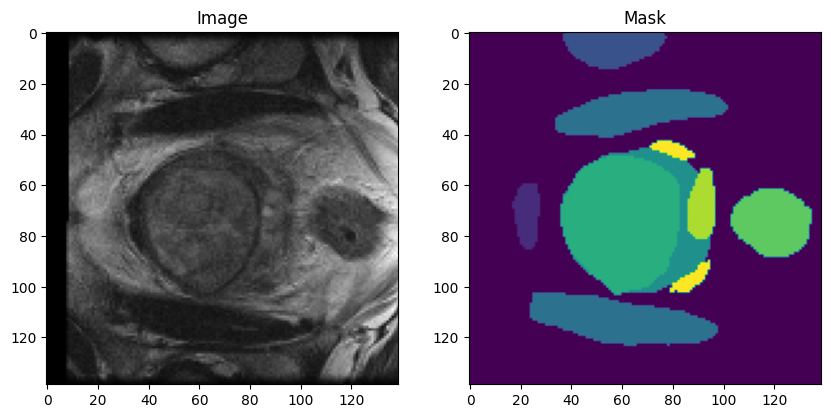

52


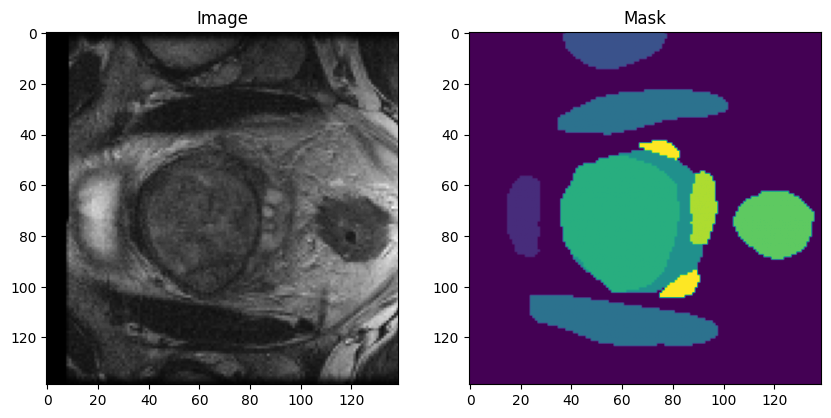

53


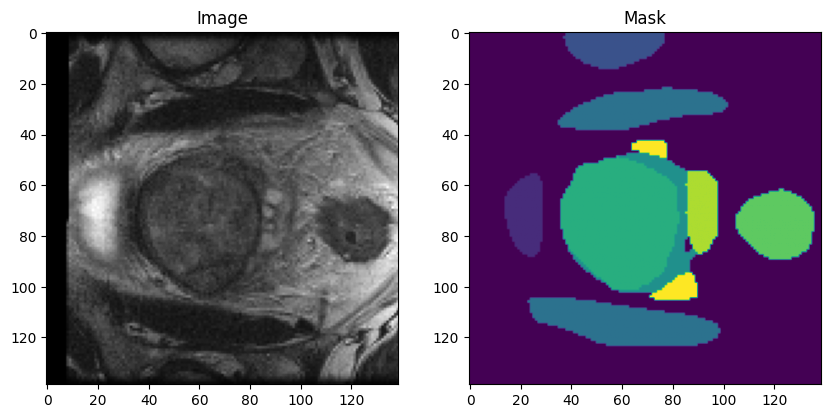

54


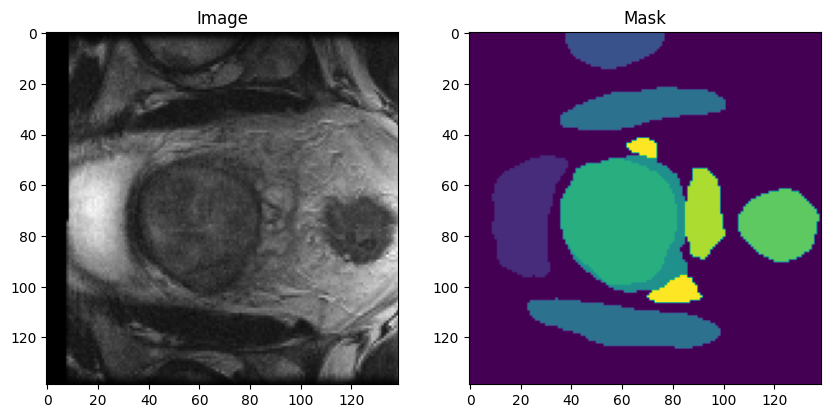

55


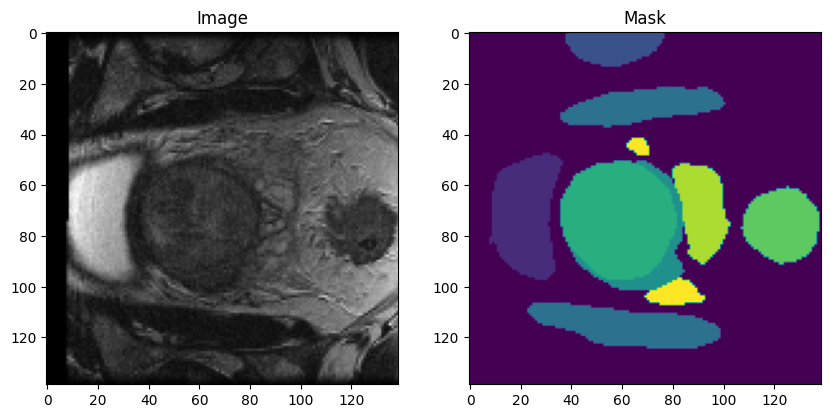

[51, 52, 53, 54, 55]


In [176]:
f_mask = 380

# Read the first image and mask
image = nib.load(train_images[f_mask]).get_fdata()
mask = nib.load(train_masks[f_mask]).get_fdata()

# Convert to tensors
image = torch.from_numpy(image)
mask = torch.from_numpy(mask)
#mask.unique().shape


#Function to display image and mask
def display_image_and_mask(image, mask, slice):
    fig, ax = plt.subplots(1, 2, figsize = (10, 5))
    ax[0].imshow(image[:, :, slice], cmap = "gray")
    ax[0].set_title("Image")
    ax[1].imshow(mask[:, :, slice])
    ax[1].set_title("Mask")
    plt.show()

full_slices = []
for i in range(mask.shape[2]):
    msk = mask[:, :, i]
    if torch.unique(msk).shape[0] == 9:
        print(i)
        full_slices.append(i)
        display_image_and_mask(image, mask, i)


print(full_slices)


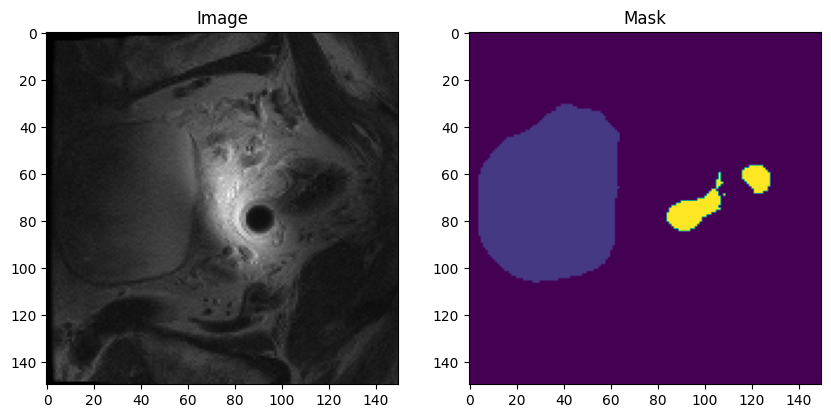

In [85]:
display_image_and_mask(image, mask, 50)

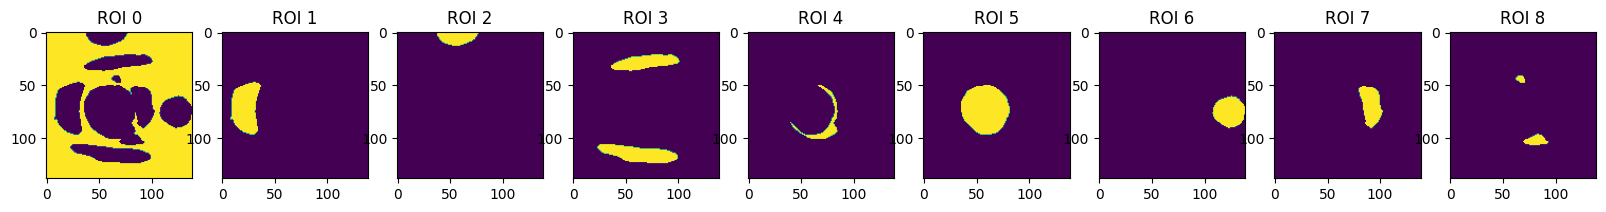

In [178]:
# Plot all ROIs
def plot_all_ROIs(mask, slice):
    fig, ax = plt.subplots(1, 9, figsize = (20, 7))
    for roi in range(9):
        ax[roi].imshow(mask[:, :, slice] == roi)
        ax[roi].set_title(f"ROI {roi}")
    plt.show()

plot_all_ROIs(mask, 55)

In [174]:
mask[:, :, 23].unique()

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8.], dtype=torch.float64)

tensor([0., 4., 5.], dtype=torch.float64)


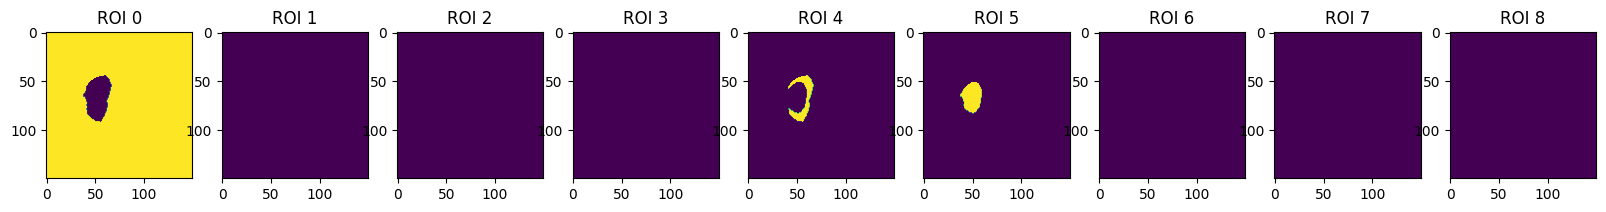

In [154]:
# Make mask not equal to 1 or 2 zero
mask2 = mask.clone().detach()
mask2[(mask2 != 4) & (mask2 != 5)] = 0
print(mask2.unique())
plot_all_ROIs(mask2, 36)

segmenting the central gland could be a plausible main segmentation task in this project since it is an important region in prostate cancer diagnosis and treatment planning. The segmentation of other surrounding structures or classification tasks can be used as auxiliary tasks to improve the main task. For instance, segmenting the bladder, rectum, and seminal vesicles can help to avoid irradiation of these structures during radiation therapy. Segmenting the neurovascular bundle and the obturator internus can be used for image-guided surgery to avoid nerve damage.

including bladder, bone, neurovascular bundle, obturator internus,  zone, rectum, seminal vesicle, transition zone and peripheral zone.

1BladderMask: Bladder
2BoneMask: Bone
3ObdInternMask: Obturator internus
4TZ: Transition zone
5CG: Central gland (also known as the peripheral zone)
6RectumMask: Rectum
7SV: Seminal vesicle
8NVB: Neurovascular bundle

In [40]:
organs = ["Background", "Bladder", "Bone", "Obturator internus", "Transition zone", "Central gland",
          "Rectum", "Seminal vesicle", "Neurovascular bundle"]
# Create an index dictionary
organs_dict = {organ: idx for idx, organ in enumerate(organs)}
organs_dict

{'Background': 0,
 'Bladder': 1,
 'Bone': 2,
 'Obturator internus': 3,
 'Transition zone': 4,
 'Central gland': 5,
 'Rectum': 6,
 'Seminal vesicle': 7,
 'Neurovascular bundle': 8}

In [58]:
roi_interest.shape

torch.Size([150, 150, 53])

tensor([0., 4., 5.], dtype=torch.float64)


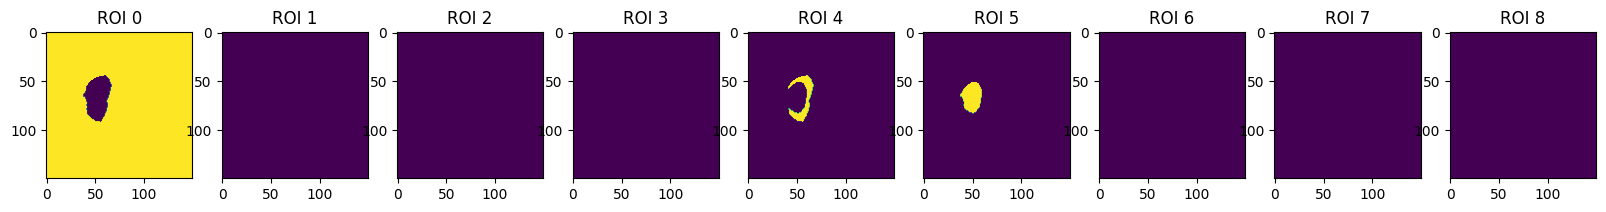

In [156]:
# Make mask not equal to 1 or 2 zero
mask2 = mask.clone().detach()
mask2[(mask2 != organs_dict["Central gland"]) & (mask2 != organs_dict["Transition zone"])] = 0
print(mask2.unique())
plot_all_ROIs(mask2, 36)
 

In [128]:
mask.unique()

tensor([0., 1., 2., 3., 4., 5., 6., 7., 8.], dtype=torch.float64)

In [ ]:
# Add 

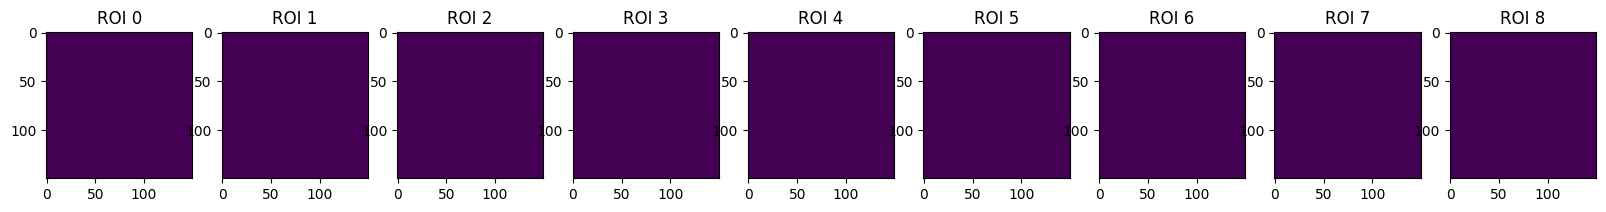

In [138]:
# Narrow down to bladder, central gland, rectum and seminal vesicle
roi_interest = (mask == organs_dict["Central gland"]) & (mask == organs_dict["Transition zone"])
#| (mask == organs_dict["Central gland"]) | (mask == organs_dict["Rectum"]) | (mask == organs_dict["Seminal vesicle"])
plot_all_ROIs(roi_interest, 38)

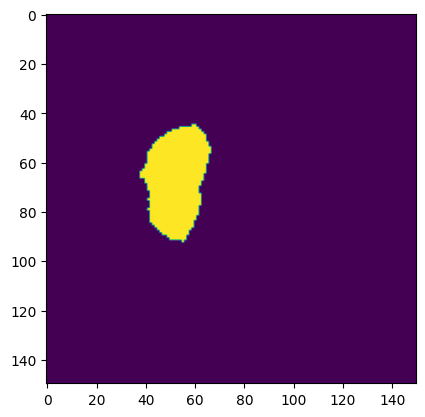

In [109]:
plt.imshow(roi_interest[:, :, 36])

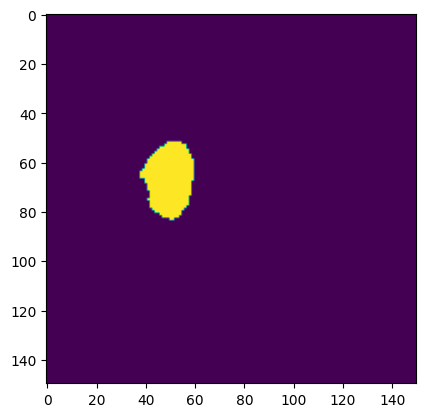

In [107]:
plt.imshow(roi_interest[:, :, 36])

In [98]:
roi_interest[:, :, 36]

tensor([[False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        ...,
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False],
        [False, False, False,  ..., False, False, False]])

In [62]:
roi_interest.unique()

tensor([False,  True])

In [38]:
organs_dict["Bladder"]

1

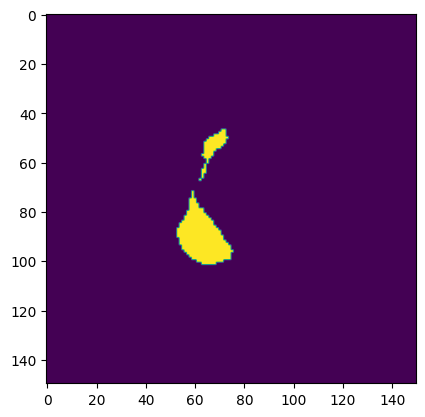

In [61]:
# Narrow down t0 ROI 6 for all slices
mask_roi_6 = mask == 7
plt.imshow(mask_roi_6[:, :, 38])

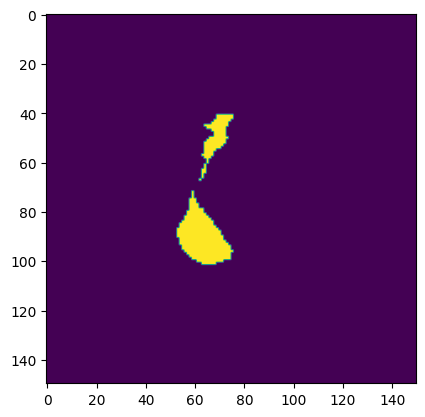

In [99]:
# Display R0I 7 and 8
roi_7_8 = (mask[:, :, 38] == 7) | (mask[:, :, 38] == 8)
plt.imshow(roi_7_8)

In [ ]:


# # Plot the image and mask
# fig, ax = plt.subplots(1, 2, figsize = (10, 5))
# ax[0].imshow(image[:, :, 0], cmap = "gray")
# ax[0].set_title("Image")
# ax[1].imshow(mask[:, :, 0])
# ax[1].set_title("Mask")
# plt.show()

# Create function to display image and mask


# Convert the image and mask to tensors
# image = torch.from_numpy(image)
# mask = torch.from_numpy(mask)

#

In [ ]:
## Implement a MTL 3D residual attention U-Net
class MTLResidualAttention3DUnet(nn.Module):
    def __init__(self, in_channels, out_channels, n_groups = 4, n_channels = [16, 32, 64, 128, 256]):
        super.__init__()

        # Define the contracting path: residual blocks followed by downsampling
        self.down_conv = nn.ModuleList(residual_block(in_chans, out_chans) for in_chans, out_chans in
                                       [(in_channels, n_channels[0]), (n_channels[0], n_channels[1]), (n_channels[1], n_channels[2]), (n_channels[2], n_channels[3])])
        self.down_samples = nn.ModuleList(down_sample() for _ in range(len(n_channels) - 1))

        # Define the bottleneck residual block
        self.bottleneck = residual_block(n_channels[3], n_channels[4])

        # Define the attention blocks
        self.attention_blocks = nn.ModuleList(attention_block(skip_channels = residuals_chans, gate_channels = gate_chans) for gate_chans, residuals_chans in
                                              [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        

        # Define the expanding path: upsample blocks, followed by crop and concatenate, followed by residual blocks
        self.upsamples = nn.ModuleList(up_sample(in_chans, out_chans) for in_chans, out_chans in
                                       [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        
        self.concat = nn.ModuleList(crop_and_concatenate() for _ in range(len(n_channels) - 1))

        self.up_conv = nn.ModuleList(residual_block(in_chans, out_chans) for in_chans, out_chans in
                                     [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        
        
        # Final 1X1 convolution layer to produce the output segmentation map:
        # The primary purpose of 1x1 convolutions is to transform the channel dimension of the feature map,
        # while leaving the spatial dimensions unchanged.
        self.final_conv = nn.Conv3d(in_channels = n_channels[0], out_channels = out_channels, kernel_size = 1, padding = 0, bias = False)

        ## --------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- ##
        ###** Add second decoder path for image reconstruction **###

        self.upsamples_recon = nn.ModuleList(up_sample(in_chans, out_chans) for in_chans, out_chans in
                                        [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        self.concat_recon = nn.ModuleList(crop_and_concatenate() for _ in range(4))
        self.up_conv_recon = nn.ModuleList(residual_block(in_chans, out_chans) for in_chans, out_chans in
                                        [(n_channels[4], n_channels[3]), (n_channels[3], n_channels[2]), (n_channels[2], n_channels[1]), (n_channels[1], n_channels[0])])
        # Final 1x1 convolution layer to produce the reconstructed image
        self.final_conv_recon = nn.Conv3d(in_channels = n_channels[0], out_channels = in_channels, kernel_size = 1, padding = 0, bias = False)

    # Pass the input through the residual attention U-Net
    def forward(self, x):
        # Store the skip connections
        skip_connections = []

        # Pass the input through the contracting path
        for down_conv, down_sample in zip(self.down_conv, self.down_samples):
            x = down_conv(x)
            skip_connections.append(x)
            x = down_sample(x)

        # Pass the output of the contracting path through the bottleneck
        x = self.bottleneck(x)
        skip_connections.append(x)

        # Define segmentation and reconstruction variables
        x_seg = x
        x_recon = x

        # Attention on the residual connections
        n = len(skip_connections)
        indices = [(n - 1 - i, n - 2 - i) for i in range(n - 1)]
        attentions = []
        for i, g_x in enumerate(indices):
            g_gate = g_x[0]
            x_residual = g_x[1]
            attn = self.attention_blocks[i](skip_connections[x_residual], skip_connections[g_gate])
            attentions.append(attn)
        attentions_recon = attentions

        #attentions = attentions[::-1]

        # Pass the output of the attention blocks through the expanding path of the segmentation path
        for up_sample, concat, up_conv in zip(self.upsamples, self.concat, self.up_conv):
            x_seg = up_sample(x_seg)
            x_seg = concat(x_seg, attentions.pop(0))
            x_seg = up_conv(x_seg)

        # Pass the output of the expanding path through the final convolution layer
        x_seg = self.final_conv(x_seg) # Output segmentation map

        # Pass the output of the attention blocks through the expanding path of the reconstruction path
        for up_sample, concat, up_conv in zip(self.upsamples_recon, self.concat_recon, self.up_conv_recon):
            x_recon = up_sample(x_recon)
            x_recon = concat(x_recon, attentions_recon.pop(0))
            x_recon = up_conv(x_recon)

        # Pass the output of the expanding path through the final convolution layer
        x_recon = self.final_conv_recon(x_recon) # Output reconstructed image

        return x_seg, x_recon




## Multi-task learning 3D unet

In this section, we create a MTL Unet which takes a 3D image as input, uses the first decoder for **image segmentation**: main task, and the second decoder for image reconstruction.

> Perhaps we can do a 3rd binary task for binary mask classification? Ask Ela..

In [3]:
import skimage
from skimage.measure import compare_ssim

ImportError: cannot import name 'compare_ssim' from 'skimage.measure' (d:\Eric\multi_task_learning\ml_cw2\multi_task_learning\.venv\lib\site-packages\skimage\measure\__init__.py)